In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from scipy.stats import percentileofscore
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/dataset1/data_match9.xlsx', engine='openpyxl')
test_data = pd.read_excel('/content/drive/MyDrive/dataset1/data_match10.xlsx', engine='openpyxl')

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [ ]:
def add_column(data):
    data["B10B-B16B"] = data["B10B"] - data["B16B"]
    data["B11B-IRB"] = data["B11B"] - data["IRB"]
    data["IRB-I2B"] = data["IRB"] - data["I2B"]
    data["WVB-B09B"] = data["WVB"] - data["B09B"]
    data["B09B-B10B"] = data["B09B"] - data["B10B"]

In [ ]:
data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:, 6:-1] = scaler.fit_transform(data.iloc[:, 6:-1])

In [ ]:
add_column(data)

In [ ]:
data.iloc[:, -5:] = scaler.fit_transform(data.iloc[:, -5:])

In [ ]:
data.loc[data['value'] > 0, 'rain'] = 1
data.loc[data['value'] == 0, 'rain'] = 0

In [ ]:
balanced_data = pd.concat((data[data['rain'] == 1], data[data['rain'] == 0].head(len(data[data['rain'] == 1]))))

In [ ]:
train_cols = ["IRB", "B10B-B16B", "B11B-IRB", "IRB-I2B", "WVB-B09B", "B09B-B10B", 
              'CAPE', 'TCC', 'TCW', 'TCWV']
x = balanced_data[train_cols]
y = balanced_data['rain'].astype('int')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
def compute_metric(name, model, X, Y):
    print(f'{name}-R2:', model.score(X,Y))
    print(f'{name}-RMSE:',mean_squared_error(Y, model.predict(X), squared=False))
    print(f'{name}-MAE:',mean_absolute_error(Y,model.predict(X)))
    print(f'{name}-Pearson r:', stats.pearsonr(Y, model.predict(X))[0])

In [ ]:
np.random.seed(42)

In [ ]:
ds_all = data.merge(X_train.drop_duplicates(), on=train_cols,
                   how='left', indicator=True)
ds_test_full = ds_all[ds_all['_merge'] == 'left_only']

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc_param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [3, 6, 8],
}
rfc_grid = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=5, n_jobs=-1, verbose=1)
rfc_grid.fit(X_train, Y_train)

In [ ]:
rfc_grid.best_params_

In [ ]:
rfc_grid = RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)
rfc_grid.fit(X_train,Y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [ ]:
print(classification_report(Y_train, rfc_grid.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     10672
           1       0.80      0.89      0.84     10557

    accuracy                           0.84     21229
   macro avg       0.84      0.84      0.84     21229
weighted avg       0.84      0.84      0.84     21229



In [ ]:
print(classification_report(Y_test, rfc_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      4492
           1       0.80      0.87      0.83      4607

    accuracy                           0.82      9099
   macro avg       0.82      0.82      0.82      9099
weighted avg       0.82      0.82      0.82      9099



In [ ]:
print(classification_report(ds_test_full['rain'].astype(int), rfc_grid.predict(ds_test_full[train_cols])))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78    131614
           1       0.07      0.86      0.12      3970

    accuracy                           0.65    135584
   macro avg       0.53      0.75      0.45    135584
weighted avg       0.97      0.65      0.76    135584



<BarContainer object of 10 artists>

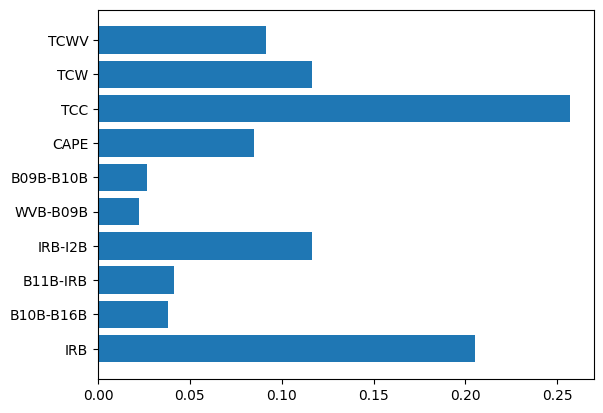

In [ ]:
plt.barh(train_cols, rfc_grid.feature_importances_)

In [ ]:
cls_train_cols = ["TCC", "IRB", "IRB-I2B", "TCW"]
imp_rfc_grid = RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)
imp_rfc_grid.fit(X_train[cls_train_cols],Y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [ ]:
print(classification_report(Y_train, imp_rfc_grid.predict(X_train[cls_train_cols])))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80     10672
           1       0.77      0.86      0.82     10557

    accuracy                           0.81     21229
   macro avg       0.81      0.81      0.81     21229
weighted avg       0.81      0.81      0.81     21229



In [ ]:
print(classification_report(Y_test, imp_rfc_grid.predict(X_test[cls_train_cols])))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      4492
           1       0.77      0.84      0.80      4607

    accuracy                           0.79      9099
   macro avg       0.80      0.79      0.79      9099
weighted avg       0.79      0.79      0.79      9099



In [ ]:
print(classification_report(ds_test_full['rain'].astype(int), imp_rfc_grid.predict(ds_test_full[cls_train_cols])))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77    131614
           1       0.06      0.83      0.12      3970

    accuracy                           0.64    135584
   macro avg       0.53      0.73      0.44    135584
weighted avg       0.96      0.64      0.75    135584



In [ ]:
dt_est = data.copy()
dt_est['pred_rain'] = imp_rfc_grid.predict(data[cls_train_cols])
X_est = dt_est[dt_est['pred_rain'] == 1][train_cols]
Y_est = dt_est[dt_est['pred_rain'] == 1]['value']
X_train_est, X_test_est, Y_train_est, Y_test_est = train_test_split(X_est, Y_est, test_size=0.3, random_state=42)
imerg = dt_est[dt_est['pred_rain'] == 1]['IMERG'].loc[Y_test_est.index]

# Random Forest Regression

In [ ]:
rfr = RandomForestRegressor(random_state=42)
rfr_param_grid = {'max_depth': [3, 7, None],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [100, 200]}
grid_rfr = GridSearchCV(rfr, param_grid=rfr_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_rfr.fit(X_train_est, Y_train_est)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 7, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)

In [ ]:
grid_rfr.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
grid_rfr = RandomForestRegressor(max_depth = None, n_estimators = 200, min_samples_leaf = 2, random_state=42)
grid_rfr.fit(X_train_est, Y_train_est)

In [ ]:
compute_metric('Random Forest Regressor Train', grid_rfr, X_train_est, Y_train_est)

In [ ]:
compute_metric('Random Forest Regressor Test', grid_rfr, X_test_est, Y_test_est)

In [ ]:
compute_metric('Random Forest Regressor Test Full', grid_rfr, ds_test_full[train_cols], ds_test_full['value'])

In [ ]:
plt.barh(train_cols, grid_rfr.feature_importances_)

In [ ]:
rg_train_cols = ["TCW", "CAPE", "IRB-I2B", "B11B-IRB"]
imp_grid_rfr = RandomForestRegressor(min_samples_split=2, n_estimators=200, random_state=42)
imp_grid_rfr.fit(X_train_est[rg_train_cols], Y_train_est)

In [ ]:
compute_metric('Random Forest Regressor Train', imp_grid_rfr, X_train_est[rg_train_cols], Y_train_est)

In [ ]:
compute_metric('Random Forest Regressor Test', imp_grid_rfr, X_test_est[rg_train_cols], Y_test_est)

In [ ]:
compute_metric('Random Forest Regressor Test Full', imp_grid_rfr, ds_test_full[rg_train_cols], ds_test_full['value'])

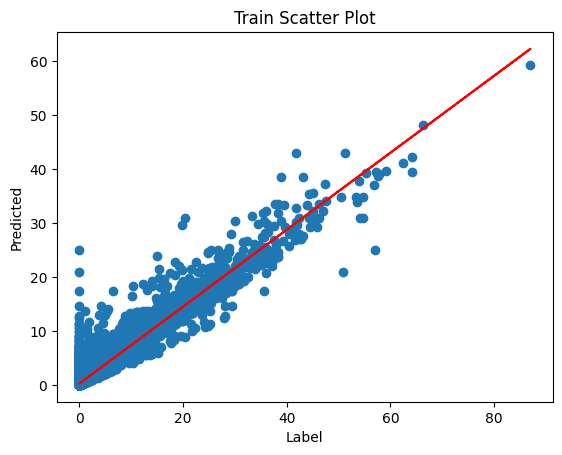

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Label')
plt.title('Train Scatter Plot')
plt.plot(Y_train_est, imp_grid_rfr.predict(X_train_est[rg_train_cols]), 'o')
a, b = np.polyfit(Y_train_est, imp_grid_rfr.predict(X_train_est[rg_train_cols]), 1)
plt.plot(Y_train_est, a * Y_train_est + b, 'r')
plt.show()

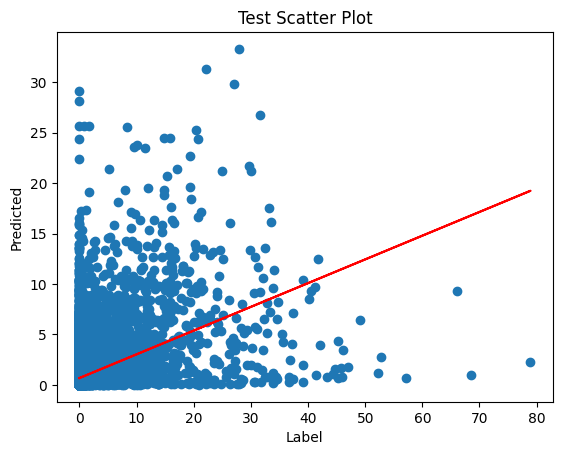

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Label')
plt.title('Test Scatter Plot')
plt.plot(Y_test_est, imp_grid_rfr.predict(X_test_est[rg_train_cols]), 'o')
a, b = np.polyfit(Y_test_est, imp_grid_rfr.predict(X_test_est[rg_train_cols]), 1)
plt.plot(Y_test_est, a * Y_test_est + b, 'r')
plt.show()

In [ ]:
imerg = ds_test_full['IMERG'].loc[ds_test_full['value'].index]

In [ ]:
print(f'IMERG-R2:', r2_score(ds_test_full['value'], imerg))
print(f'IMERG-RMSE:',mean_squared_error(ds_test_full['value'], imerg, squared=False))
print(f'IMERG-MAE:',mean_absolute_error(ds_test_full['value'], imerg))
print(f'IMERG-Pearson r:', stats.pearsonr(ds_test_full['value'], imerg)[0])

IMERG-R2: -6.1230204767271275
IMERG-RMSE: 3.5577242523940673
IMERG-MAE: 0.6853089002663912
IMERG-Pearson r: 0.14454586965444954


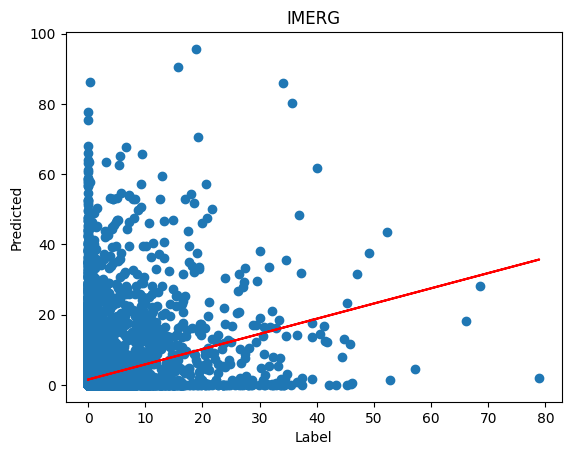

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Label')
plt.title('IMERG')
plt.plot(Y_test_est, imerg, 'o')
a, b = np.polyfit(Y_test_est, imerg, 1)
plt.plot(Y_test_est, a * Y_test_est + b, 'r')
plt.show()

# XGBoost

In [ ]:
XGB = XGBRegressor(random_state=42)
xgb_param_grid = {"learning_rate"    : [0.01, 0.10] ,
                  "max_depth"        : [6, 8],
                  "min_child_weight" : [1, 5],
                  "n_estimators"     : [100, 200]}
grid_xgb = GridSearchCV(XGB, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_est, Y_train_est)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 8],
                         'min_child_weight': [1, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

In [ ]:
grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 200}

In [ ]:
grid_xgb = XGBRegressor(max_depth = 15, learning_rate = 0.1, min_child_weight = 5, n_estimators = 200, random_state=42)
grid_xgb.fit(X_train_est, Y_train_est)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
compute_metric('XGBoost Regressor Train', grid_xgb, X_train_est, Y_train_est)

XGBoost Regressor Train-R2: 0.8980109265670999
XGBoost Regressor Train-RMSE: 1.1228955734277004
XGBoost Regressor Train-MAE: 0.39266653034323884
XGBoost Regressor Train-Pearson r: 0.9552765349216104


In [ ]:
compute_metric('XGBoost Regressor Test', grid_xgb, X_test_est, Y_test_est)

XGBoost Regressor Test-R2: 0.18849333865182005
XGBoost Regressor Test-RMSE: 3.1890778474087225
XGBoost Regressor Test-MAE: 1.053100496610622
XGBoost Regressor Test-Pearson r: 0.46783692375215746


In [ ]:
compute_metric('XGBoost Regressor Test Full', grid_xgb, ds_test_full[train_cols], ds_test_full['value'])

XGBoost Regressor Test Full-R2: -0.22276656653727245
XGBoost Regressor Test Full-RMSE: 1.4740491533324056
XGBoost Regressor Test Full-MAE: 0.7801982355549975
XGBoost Regressor Test Full-Pearson r: 0.5293714074444237


# CatBoost

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
CBR = CatBoostRegressor()
cbr_param_grid = {"depth"    : [10, 11, 15, 16],
                  "learning_rate" : [0.05, 0.1, 0.2, 0.3],
                  "iterations"     : [10, 50, 100]}
grid_cbr = GridSearchCV(CBR, param_grid=cbr_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_cbr.fit(X_train_est, Y_train_est)

In [ ]:
grid_cbr.best_params_

{'depth': 11, 'iterations': 100, 'learning_rate': 0.1}

In [ ]:
grid_cbr = CatBoostRegressor(depth = 16, iterations = 100, learning_rate = 0.3, random_state=42)
grid_cbr.fit(X_train_est, Y_train_est)

In [ ]:
compute_metric('CatBoost Regressor Train', grid_cbr, X_train_est, Y_train_est)

CatBoost Regressor Train-R2: 0.7922976783246573
CatBoost Regressor Train-RMSE: 1.6024453315455904
CatBoost Regressor Train-MAE: 0.6525910483353619
CatBoost Regressor Train-Pearson r: 0.9044474964506639


In [ ]:
compute_metric('CatBoost Regressor Test', grid_cbr, X_test_est, Y_test_est)

CatBoost Regressor Test-R2: 0.19090913381146957
CatBoost Regressor Test-RMSE: 3.1843274852598884
CatBoost Regressor Test-MAE: 1.1141024169214568
CatBoost Regressor Test-Pearson r: 0.45213151702438903


In [ ]:
compute_metric('CatBoost Regressor Test Full', grid_cbr, ds_test_full[train_cols], ds_test_full['value'])

CatBoost Regressor Test Full-R2: 0.3089747421132396
CatBoost Regressor Test Full-RMSE: 1.108120906800525
CatBoost Regressor Test Full-MAE: 0.484978067814996
CatBoost Regressor Test Full-Pearson r: 0.6109437553193762
